In [1]:

import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp
from genpen.utils import Paper
from scipy import stats
import geopandas
from shapely.errors import TopologicalError
import functools
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure

from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from numpy.random import default_rng

def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

from PIL import Image


import cv2
from rasterio import features
import rasterio
%load_ext autoreload
%autoreload 2

In [2]:
import pydiffvg as dg
import torch
import skimage
import numpy as np
from torchvision.transforms import functional as TF
from IPython import display

In [3]:
def finalize_image(img, gamma = 2.2, normalize = False, as_Image=False):
    if not isinstance(img, np.ndarray):
        img = img.data.numpy()
    if normalize:
        img_rng = np.max(img) - np.min(img)
        if img_rng > 0:
            img = (img - np.min(img)) / img_rng
    img = np.clip(img, 0.0, 1.0)
    if img.ndim==2:
        #repeat along the third dimension
        img=np.expand_dims(img,2)
    img[:, :, :3] = np.power(img[:, :, :3], 1.0/gamma)
    img = (img * 255).astype(np.uint8)
    if as_Image:
        img = Image.fromarray(img)
    return img

In [4]:
class LineTensor(object):
    
    def __init__(
        self,
        linestring,
    ):
        self.init_ls = linestring
        self.pts = [p for p in self.init_ls.coords]
        self.tensor = torch.tensor(self.pts, requires_grad=True)
        self.init_loc_pt = self.ls.centroid
        self.init_loc_tensor = torch.tensor(np.array(self.init_loc_pt), requires_grad=True)
        
    @property
    def ls(self):
        return LineString(self.tensor.cpu().data.numpy())

In [5]:
image_path= '/home/naka/art/vqgan_clip/a_charcoal_drawing_of_mountains.png'
paper_size:str = '7x5 inches'
border:float=10  # mm
image_rescale_factor:float=2
smooth_disk_size:int=1
hist_clip_limit=0.1
hist_nbins=32
intensity_min=0.
intensity_max=1.
hatch_spacing_min=0.6  # mm
hatch_spacing_max=1.5 # mm
pixel_width=1 # mm
pixel_height=1 # mm
angle_jitter='0'  # degrees
pixel_rotation='0'  # degrees
merge_tolerances=[0.5, 0.8, 1.2]  # mm
simplify_tolerances=[0.2, 0.4]  # mm
savedir='/home/naka/art/plotter_svgs'

In [6]:
Path(image_path).as_uri()

'file:///home/naka/art/vqgan_clip/a_charcoal_drawing_of_mountains.png'

In [7]:
raw_img = Image.open(Path(image_path).as_posix())

In [8]:
gamma = 1.0
# target = torch.from_numpy(skimage.io.imread(Path(image_path))).to(torch.float32) / 255.0
target = torch.from_numpy(np.array(raw_img.resize([int(d*image_rescale_factor) for d in raw_img.size]))).to(torch.float32) / 255.0
target = target.pow(gamma)
target = target.to(dg.get_device())
target = target.unsqueeze(0)
target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
#target = torch.nn.functional.interpolate(target, size = [256, 256], mode = 'area')
canvas_width, canvas_height = target.shape[3], target.shape[2]

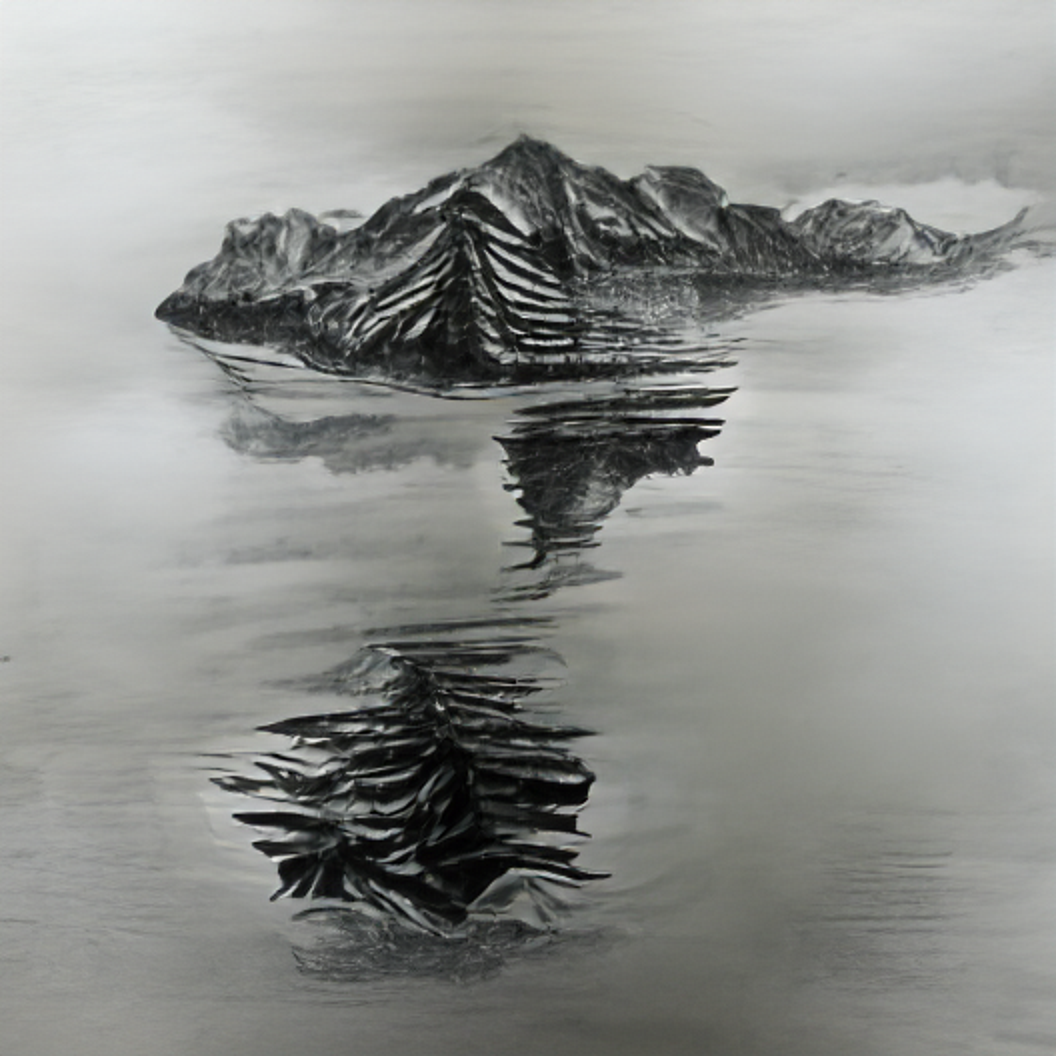

In [9]:
TF.to_pil_image(target.cpu().squeeze())

In [ ]:
gray = TF.to_grayscale(TF.to_pil_image(target.cpu().squeeze()))

# doin it myself

In [ ]:
img_rescale = rescale(np.array(gray), image_rescale_factor)
# img_renorm = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)
target_img = img_rescale

In [ ]:
drawbox = box(0, 0, img_rescale.shape[1], img_rescale.shape[0])
db = gp.Shape(drawbox)

In [ ]:
# calc dominant angle
selem = disk(smooth_disk_size)
filt_img = np.stack([filters.rank.mean(img_renorm[:,:,ii], selem) for ii in range(img_renorm.shape[2])], axis=2)

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
ax.imshow(filt_img)

In [ ]:
filt_img_summed = filt_img.sum(axis=2)

In [ ]:
angle_farid = local_angle(filters.farid_h(filt_img_summed), filters.farid_v(filt_img_summed))

In [ ]:
plt.imshow(angle_farid)

In [ ]:
ls = gp.make_angled_line(deg=45, length=0.1, center=(5,5))

In [ ]:
trans_x_gen = stats.norm(loc=0, scale=0.1).rvs
trans_y_gen = stats.norm(loc=0, scale=0.1).rvs
n_lines = 10000
line_length_gen = lambda: 10

In [ ]:
rng = default_rng()
def draw_new_location():
    return inds[np.random.choice(len(inds), p=p)]

def add_new_line(row, col):
    deg = np.degrees(angle_farid[row, col])
    x = np.interp(col, (0, img_renorm.shape[1]), (db.left, db.right)) + trans_x_gen()
    y = np.interp(row, (0, img_renorm.shape[0]), (db.bottom, db.top)) + trans_y_gen()
    return gp.make_angled_line(deg=deg, length=line_length_gen(), center=(x,y))

def lines_to_img(lss, invert=True, default_value=0.2, rescale=True, out_shape=None, **kwargs):
    gen_img = features.rasterize(
        [lss], 
        out_shape=out_shape, 
        dtype='float', 
        merge_alg=rasterio.enums.MergeAlg.add,
        default_value=default_value,
        **kwargs
    )
    if invert:
        gen_img = 1 - gen_img
    if rescale:
        gen_img = minmax_scale(gen_img)
    return gen_img

def calc_loss(generated_img, target_img):
    return ((generated_img - target_img)**2).sum()

In [ ]:
row_inds, col_inds = np.indices(img_renorm.shape[:2])

inds = np.array([(row, col) for row, col in zip(row_inds.ravel(), col_inds.ravel())])

intensities = img_renorm.sum(axis=2).ravel()
intensities = intensities - intensities.max()
p = intensities/intensities.sum()


lss = []

In [ ]:
n_steps = 1000
losses = []

In [ ]:
for ii in tqdm(range(n_steps)):
    row, col = draw_new_location()
    ls = add_new_line(row, col)
    lss.append(ls)

In [ ]:
for ii in tqdm(range(n_steps)):
    row, col = draw_new_location()
    ls = add_new_line(row, col)
    lss.append(ls)
    generated_img = lines_to_img(gp.merge_LineStrings(lss), out_shape=(img_rescale.shape[0], img_rescale.shape[1]))
    loss = calc_loss(generated_img, target_img)
    losses.append(loss)

In [ ]:
plt.plot(losses)

In [ ]:
Image.fromarray((generated_img*255).astype('uint8'))

In [ ]:
big_img = lines_to_img(sa.scale(gp.merge_LineStrings(lss), xfact=2, yfact=2, origin=(0,0)), out_shape=(img_rescale.shape[0]*2, img_rescale.shape[1]*2))

In [ ]:
Image.fromarray((big_img*255).astype('uint8'))

In [ ]:
plt.imshow()

In [ ]:
lss = []
for row, col in pix_inds:
    deg = np.degrees(angle_farid[row, col])
    x = np.interp(col, (0, img_renorm.shape[1]), (db.left, db.right)) + trans_x_gen()
    y = np.interp(row, (0, img_renorm.shape[0]), (db.bottom, db.top)) + trans_y_gen()
    ls = gp.make_angled_line(deg=deg, length=line_length_gen(), center=(x,y))
    lss.append(ls)

In [ ]:
lss = gp.merge_LineStrings(lss)

In [ ]:
plt.imshow(rastered)

In [ ]:
rhps = []
prms = []
for y, row in tqdm(enumerate(img_renorm[:,:, ii])):
    for x, intensity in enumerate(row):

        p = gp.centered_box(Point(x, y), width=pixel_width, height=pixel_height)
        a = np.degrees(angle_farid[y, x])
        prm = {
            'geometry':p,
            'x':x,
            'y':y,
            'raw_pixel_width':pixel_width,
            'raw_pixel_height':pixel_height,
            'intensity': intensity,
            'angle':a,
            'group': 'raw_hatch_pixel',

        }
        prms.append(prm)
raw_hatch_pixels = geopandas.GeoDataFrame(prms)

In [ ]:
gp.merge_LineStrings(rhps[0].geometry)

# diffvg

In [11]:

# Use GPU if available
dg.set_use_gpu(torch.cuda.is_available())

In [12]:
drawbox = box(0, 0, target.shape[3], target.shape[2])
db = gp.Shape(drawbox)

In [13]:
out_shape = np.array((db.height, db.width)).round().astype(int)

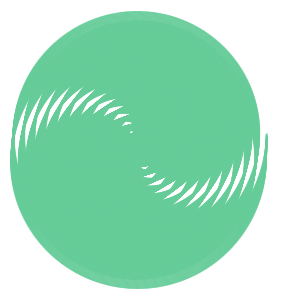

In [14]:
n_init_lines = 10000


thetas = np.linspace(0, np.pi * 28, n_init_lines)
radii = np.linspace(10, db.width*0.45, n_init_lines)

path_pt_sets = []
lss = []
lts = []
for theta, r in zip(thetas, radii):
    xc = db.p.centroid.x + 0
    yc = db.p.centroid.y + 0
    loc = (np.cos(theta)*r + xc, np.sin(theta)*r + yc)
    ls = gp.make_angled_line(
        deg=theta, 
#         deg=90,
        length=105, 
        center=loc)
    lss.append(ls)
    lt = LineTensor(ls)
    lts.append(lt)
    
gp.merge_LineStrings([lt.ls for lt in lts])


In [ ]:
rng = default_rng()

trans_x_gen = stats.norm(loc=0, scale=0.1).rvs
trans_y_gen = stats.norm(loc=0, scale=0.1).rvs
line_length_gen = lambda: 25

row_inds, col_inds = np.indices(target.shape[2:])

inds = np.array([(row, col) for row, col in zip(row_inds.ravel(), col_inds.ravel())])

intensities = target.cpu().data.numpy().sum(axis=1).squeeze().ravel()
intensities = intensities - intensities.max()
p = intensities/intensities.sum()


lss = []
lts = []
n_steps = 50
losses = []
for ii in tqdm(range(n_steps)):
    row, col = inds[np.random.choice(len(inds), p=p)]
    x = np.interp(col, (0, target.shape[3]), (db.left, db.right)) + trans_x_gen()
    y = np.interp(row, (0, target.shape[2]), (db.bottom, db.top)) + trans_y_gen()
    ls = gp.make_angled_line(deg=90, length=line_length_gen(), center=(x,y))
    lt = LineTensor(ls)
    lts.append(lt)
    
gp.merge_LineStrings([lt.ls for lt in lts])

In [ ]:
path_pt_sets = []
lts = []
n_init_lines = 1500
for ii in range(n_init_lines):
    loc = gp.get_random_point_in_polygon(db.p)
    ls = gp.make_angled_line(deg=np.random.uniform(0, 360), length=np.random.uniform(2, 30), center=loc)
    lt = LineTensor(ls)
    lts.append(lt)
    
gp.merge_LineStrings([lt.ls for lt in lts])

In [ ]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(drawbox, xstep=7, ystep=7, flatmesh=True)
lss = []
lts = []
for x, y in zip(xs, ys):
    ls = gp.make_angled_line(
        deg=0,
        length=9, 
        center=(x,y))
    lss.append(ls)
    lt = LineTensor(ls)
    lts.append(lt)
print(len(lts))
gp.merge_LineStrings([lt.ls for lt in lts])

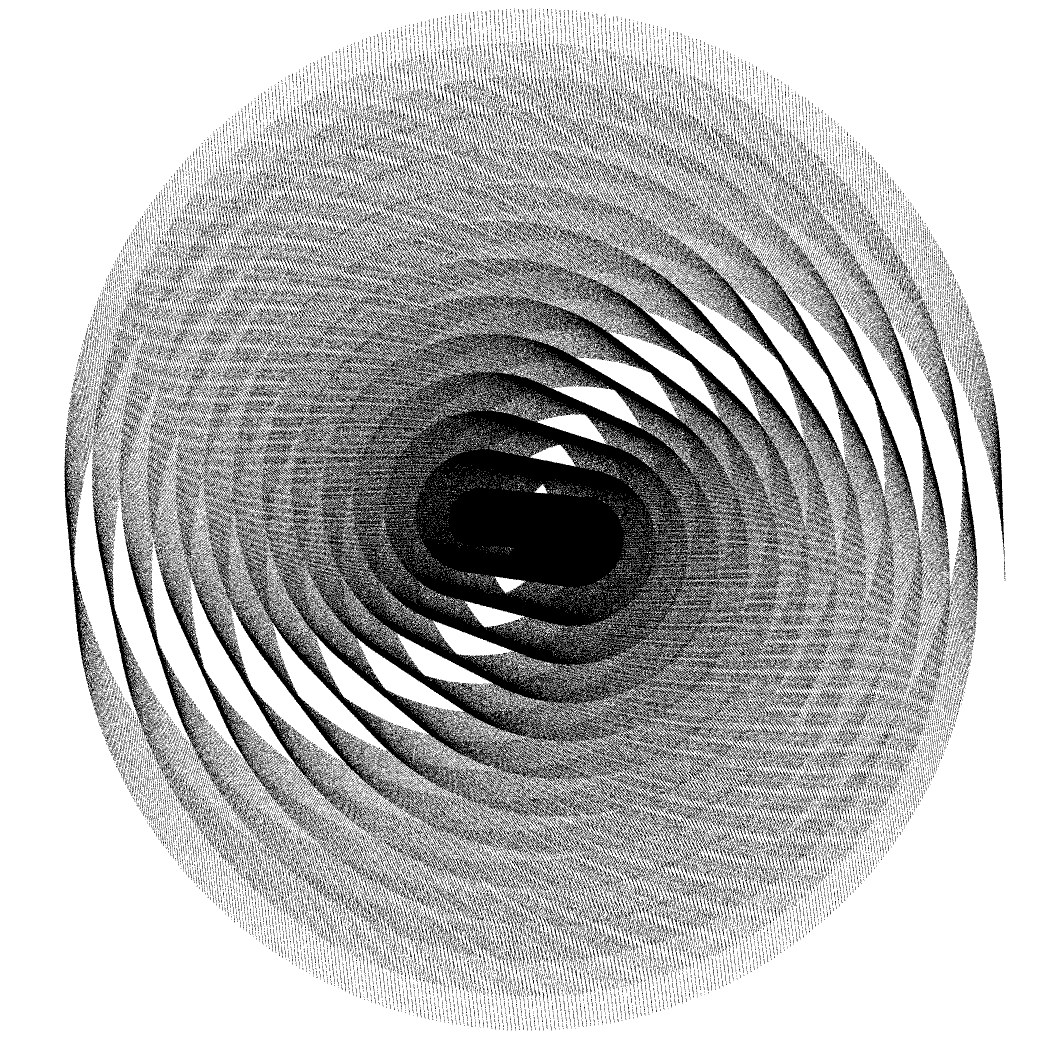

In [17]:
canvas_width, canvas_height = target.shape[3], target.shape[2]
num_control_points = torch.tensor([0])
shapes = []
shape_groups = []
for ii, lt in enumerate(lts):
    path = dg.Path(num_control_points = num_control_points,
                         points = lt.tensor,
                         is_closed = False,
                         stroke_width = torch.tensor(0.2))
    shapes.append(path)
    path_group = dg.ShapeGroup(shape_ids = torch.tensor([ii]),
                                     fill_color = torch.tensor([0.0, 0.0, 0.0, 0.0]),
                                     stroke_color = torch.tensor([0., 0., 0., 1]))
    shape_groups.append(path_group)
    
    
scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = dg.RenderFunction.apply
img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
# target = img.clone()

angle_targets = [torch.tensor(0) for shape in shapes]

# init
rendered_img = finalize_image(img.cpu(), as_Image=True)
rendered_img

In [18]:
rendered_img.save('/home/naka/art/raster_images/test_render.png')

In [25]:
img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
img = finalize_image(img.cpu(), as_Image=True)


In [29]:
background = Image.new('RGBA', img.size, (255,255,255))

alpha_composite = Image.alpha_composite(background, img)

In [31]:
alpha_composite.save('/home/naka/art/raster_images/test_render.png')

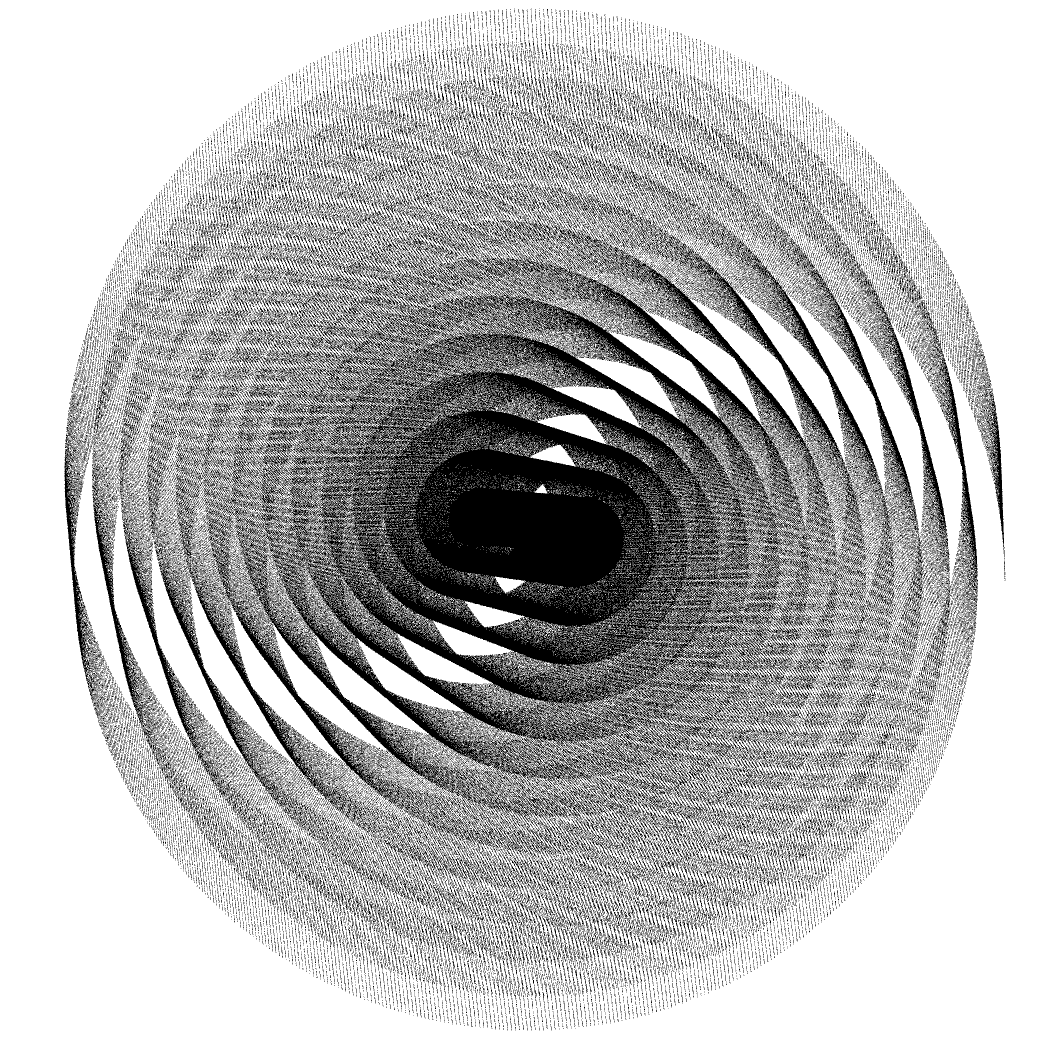

In [34]:
alpha_composite

In [36]:
quality_val = 100
alpha_composite.convert('RGB').save('/home/naka/art/raster_images/test_render.jpeg', quality=quality_val)

In [ ]:
rng = default_rng()

display_freq = 5

losses = []
length_losses = []
reconstruction_losses = []
overlap_losses = []
# Optimize

points_optim = torch.optim.Adam([lt.tensor for lt in lts], lr=1e0)

length_penalty = 1e-2
target_length = 5

overlap_threshold = 0.81
overlap_penalty = 1e-5

angle_penalty = 1e-4

displacement_penalty = 1e-1

total_n_pixels = canvas_height * canvas_width

In [ ]:
# Run 200 Adam iterations.
for t in tqdm(range(1000)):
    points_optim.zero_grad()
    scene_args = dg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,     # num_samples_x
                 2,     # num_samples_y
                 t+1,   # seed
                 None, # background_image
                 *scene_args)
    
    
        
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = dg.get_device()) * (1 - img[:, :, 3:4])
    # Save the intermediate render.
    img = img[:, :, :3]
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    # calc reconstruction loss
    reconstruction_loss = (img - target).pow(2).sum()
    
    dvecs = [lt.tensor.diff(axis=0) for lt in lts]
    
    mags = [dvec.norm(p=2) for dvec in dvecs]  # calc magnitude of lines
    mag_losses = [(mag - target_length).pow(2) for mag in mags]  # calculate penalty on individual lines
    length_losses = [mag_loss * length_penalty for mag_loss in mag_losses]  # scale magnitude penalties
    
    angles = [torch.atan2(dvec[:, 0], dvec[:, 1]) for dvec in dvecs]
    angle_losses = [(angle_targets[ii] - angle).pow(2) * angle_penalty for ii, angle in enumerate(angles)]
    
    displacements = [(lt.init_loc_tensor - lt.tensor.mean(axis=0)).norm(p=2) for lt in lts]
    displacement_losses = [displacement.pow(2) * displacement_penalty for displacement in displacements]
    
    individual_losses = [length_loss + angle_loss + displacement_loss for length_loss, angle_loss, displacement_loss in zip(length_losses, angle_losses, displacement_losses)]
    [il.backward() for il in individual_losses]
    
    
    overlap_loss = (img - overlap_threshold).clip(0, 1).pow(2).sum().pow(0.5) * overlap_penalty
       
    loss = reconstruction_loss + overlap_loss
    
    
#     # Backpropagate the gradients.
    loss.backward()
    points_optim.step()
    
    losses.append(loss.clone().cpu().detach().numpy())
#     length_losses.append(length_loss.clone().cpu().detach().numpy())
    overlap_losses.append(overlap_loss.clone().cpu().detach().numpy())
    reconstruction_losses.append(reconstruction_loss.clone().cpu().detach().numpy())

    # Take a gradient descent step.
    
    if t % display_freq == 0:
        display.clear_output(wait=True)
        finalize_image(img.cpu().squeeze().permute(1, 2, 0), as_Image=True).save('progress.png')
        display.display(display.Image('progress.png'))
    
# Render the final result.
scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
img = render(canvas_width, # width
             canvas_height, # height
             2,     # num_samples_x
             2,     # num_samples_y
             202,    # seed
             None, # background_image
             *scene_args)
# Save the images and differences.
finalize_image(img.cpu(), as_Image=True)

In [ ]:
length_loss

In [ ]:
f,ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(np.stack(losses), label='total')
# ax.plot(np.stack(length_losses), label='length penalty')
ax.plot(np.stack(overlap_losses), label='overlap')
ax.plot(np.stack(reconstruction_losses), label='reconstruction')
ax.legend()

In [ ]:
f,ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(np.stack(length_losses), label='overlap')

ax.legend()

In [ ]:
import fn

In [ ]:
plot_id = fn.new_plot_id()

In [ ]:
savedir='/home/naka/art/plotter_svgs'

In [ ]:
lt.tensor.cpu().data.numpy()

In [ ]:
mls = gp.merge_LineStrings([LineString(lt.tensor.cpu().data.numpy()) for lt in lts])

In [ ]:
# make page
paper_size = '7x5 inches'
border:float=10
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)
db = gp.Poly(drawbox)

In [ ]:
sk = vsketch.Vsketch()

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')

sk.geometry(gp.make_like(mls, drawbox))
    
sk.display(color_mode='layer')

In [ ]:
merge_tolerances=[0.1, 0.2, 0.3, 0.4]  # mm
simplify_tolerances=[0.1, 0.2]  # mm

In [ ]:
sk.vpype('splitall')
        
    
for tolerance in tqdm(merge_tolerances):
    sk.vpype(f'linemerge --tolerance {tolerance}mm')

# for tolerance in tqdm(simplify_tolerances):
#     sk.vpype(f'linesimplify --tolerance {tolerance}mm')

sk.vpype('linesort')
sk.display()

In [ ]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

In [ ]:
display.display

In [ ]:
from subprocess import call
call(["ffmpeg", "-framerate", "24", "-i",
    "results/single_stroke/iter_%d.png", "-vb", "20M",
    "results/single_stroke/out.mp4"])

In [ ]:
npimg = to_np(img.cpu())

In [ ]:
plt.imshow(npimg)

In [ ]:
pydiffvg.imwrite?

# connected?

In [ ]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(drawbox, xstep=12, ystep=12, flatmesh=True)
lss = []
lts = []
for x, y in zip(xs, ys):
    ls = gp.make_angled_line(
        deg=0,
        length=6, 
        center=(x,y))
    lss.append(ls)
    lt = LineTensor(ls)
    lts.append(lt)
    
print(len(lts))
    
gp.merge_LineStrings([lt.ls for lt in lts])

In [ ]:
lts

In [ ]:
pt0 = torch.tensor([10., 10. ], requires_grad=True)
pt1 = torch.tensor([50., 50. ], requires_grad=True)
pt2 = torch.tensor([50., 90. ], requires_grad=True)
pts = [pt0, pt1, pt2]

line0 = torch.cat([pt0.unsqueeze(dim=0), pt1.unsqueeze(dim=0)], dim=0)
line1 = torch.cat([pt1.unsqueeze(dim=0), pt2.unsqueeze(dim=0)], dim=0)
lts = [line0, line1]

In [ ]:
canvas_width, canvas_height = target.shape[3], target.shape[2]
num_control_points = torch.tensor([0])
shapes = []
shape_groups = []
for ii, lt in enumerate(lts):
    path = dg.Path(num_control_points = torch.zeros(1),
                         points = lt,
                         is_closed = False,
                         stroke_width = torch.tensor(1))
    shapes.append(path)
    path_group = dg.ShapeGroup(shape_ids = torch.tensor([ii]),
                                     fill_color = torch.tensor([0.0, 0.0, 0.0, 0.0]),
                                     stroke_color = torch.tensor([0., 0., 0., 1]))
    shape_groups.append(path_group)
    
    
scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = dg.RenderFunction.apply
img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
# target = img.clone()

# angle_targets = [torch.tensor(0) for shape in shapes]

# init
finalize_image(img.cpu(), as_Image=True)

In [ ]:
def line_render(all_points, all_widths, all_alphas, force_cpu=True,
                canvas_size=32, colors=None):
    dev = all_points.device
    if force_cpu:
        all_points = all_points.to("cpu")
        all_widths = all_widths.to("cpu")
        all_alphas = all_alphas.to("cpu")

        if colors is not None:
            colors = colors.to("cpu")

    all_points = 0.5*(all_points + 1.0) * canvas_size

    eps = 1e-4
    all_points = all_points + eps*th.randn_like(all_points)

    bs, num_segments, _, _ = all_points.shape
    n_out = 3 if colors is not None else 1
    output = th.zeros(bs, n_out, canvas_size, canvas_size,
                      device=all_points.device)

    scenes = []
    for k in range(bs):
        shapes = []
        shape_groups = []
        for p in range(num_segments):
            points = all_points[k, p].contiguous().cpu()
            num_ctrl_pts = th.zeros(1, dtype=th.int32)
            width = all_widths[k, p].cpu()
            alpha = all_alphas[k, p].cpu()
            if colors is not None:
                color = colors[k, p]
            else:
                color = th.ones(3, device=alpha.device)

            color = th.cat([color, alpha.view(1,)])

            path = pydiffvg.Path(
                num_control_points=num_ctrl_pts, points=points,
                stroke_width=width, is_closed=False)
            shapes.append(path)
            path_group = pydiffvg.ShapeGroup(
                shape_ids=th.tensor([len(shapes) - 1]),
                fill_color=None,
                stroke_color=color)
            shape_groups.append(path_group)

        # Rasterize
        scenes.append((canvas_size, canvas_size, shapes, shape_groups))
        raster = render(canvas_size, canvas_size, shapes, shape_groups,
                        samples=2)
        raster = raster.permute(2, 0, 1).view(4, canvas_size, canvas_size)

        alpha = raster[3:4]
        if colors is not None:  # color output
            image = raster[:3]
            alpha = alpha.repeat(3, 1, 1)
        else:
            image = raster[:1]

        # alpha compositing
        image = image*alpha
        output[k] = image

    output = output.to(dev)

    return output, scenes

In [ ]:
from torch import nn

In [ ]:
point_predictor = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh()  # bound spatial extent
)

width_predictor = nn.Sequential(
    nn.Linear(1, 10),
    nn.Sigmoid()
)

alpha_predictor = nn.Sequential(
    nn.Linear(1, 10),
    nn.Sigmoid()
)

In [ ]:
pts = [lt.tensor for lt in lts]
widths = [1. for lt in lts]
alphas = [1. for lt in lts]

In [ ]:
line_render(all_points=point_predictor, all_widths=width_predictor, all_alphas=alpha_predictor)

In [ ]:
rng = default_rng()

display_freq = 5

losses = []
length_losses = []
reconstruction_losses = []
overlap_losses = []
# Optimize

points_optim = torch.optim.Adam(pts, lr=1e0)

length_penalty = 1e-3
target_length = 20

overlap_threshold = 0.81
overlap_penalty = 1e-5

angle_penalty = 1e-8

displacement_penalty = 1e-8

total_n_pixels = canvas_height * canvas_width

In [ ]:
# Run 200 Adam iterations.
for t in tqdm(range(1000)):
    points_optim.zero_grad()
    
    
    scene_args = dg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,     # num_samples_x
                 2,     # num_samples_y
                 t+1,   # seed
                 None, # background_image
                 *scene_args)
    
    
        
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = dg.get_device()) * (1 - img[:, :, 3:4])
    # Save the intermediate render.
    img = img[:, :, :3]
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    # calc reconstruction loss
    reconstruction_loss = (img - target).pow(2).sum()
    
#     dvecs = [lt.tensor.diff(axis=0) for lt in lts]
    
#     mags = [dvec.norm(p=2) for dvec in dvecs]  # calc magnitude of lines
#     mag_losses = [(mag - target_length).pow(2) for mag in mags]  # calculate penalty on individual lines
#     length_losses = [mag_loss * length_penalty for mag_loss in mag_losses]  # scale magnitude penalties
    
#     angles = [torch.atan2(dvec[:, 0], dvec[:, 1]) for dvec in dvecs]
#     angle_losses = [(angle_targets[ii] - angle).pow(2) * angle_penalty for ii, angle in enumerate(angles)]
    
#     displacements = [(lt.init_loc_tensor - lt.tensor.mean(axis=0)).norm(p=2) for lt in lts]
#     displacement_losses = [displacement.pow(2) * displacement_penalty for displacement in displacements]
    
#     individual_losses = [length_loss + angle_loss + displacement_loss for length_loss, angle_loss, displacement_loss in zip(length_losses, angle_losses, displacement_losses)]
#     [il.backward() for il in individual_losses]
    
    
#     overlap_loss = (img - overlap_threshold).clip(0, 1).pow(2).sum().pow(0.5) * overlap_penalty
       
    loss = reconstruction_loss
    
    
#     # Backpropagate the gradients.
    loss.backward(retain_graph = True)
    points_optim.step()
    
    losses.append(loss.clone().cpu().detach().numpy())
#     length_losses.append(length_loss.clone().cpu().detach().numpy())
#     overlap_losses.append(overlap_loss.clone().cpu().detach().numpy())
    reconstruction_losses.append(reconstruction_loss.clone().cpu().detach().numpy())

    # Take a gradient descent step.
    
    if t % display_freq == 0:
        display.clear_output(wait=True)
        finalize_image(img.cpu().squeeze().permute(1, 2, 0), as_Image=True).save('progress.png')
        display.display(display.Image('progress.png'))
    
# Render the final result.
scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
img = render(canvas_width, # width
             canvas_height, # height
             2,     # num_samples_x
             2,     # num_samples_y
             202,    # seed
             None, # background_image
             *scene_args)
# Save the images and differences.
finalize_image(img.cpu(), as_Image=True)

In [ ]:
length_loss

In [ ]:
f,ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(np.stack(losses), label='total')
# ax.plot(np.stack(length_losses), label='length penalty')
ax.plot(np.stack(overlap_losses), label='overlap')
ax.plot(np.stack(reconstruction_losses), label='reconstruction')
ax.legend()

In [ ]:
drawbox = box(0, 0, img_rescale.shape[1], img_rescale.shape[0])
db = gp.Shape(drawbox)

In [ ]:
out_shape = np.array((db.height, db.width)).round().astype(int)

In [ ]:
n_init_lines = 2

n_points_per_path = 10

thetas = np.linspace(0, np.pi * 1.8, n_points_per_path)
radii = np.linspace(db.width*0.2, db.width*0.2, n_points_per_path)

path_pt_sets = []
for ii in range(n_init_lines):
    xc = db.p.centroid.x + rng.normal()
    yc = db.p.centroid.y + rng.normal()
    pts = [np.array((np.cos(theta)*r + xc, np.sin(theta)*r + yc)) for theta, r in zip(thetas, radii)]
#     pts.append(pts[0])
    path_pt_sets.append(pts)

In [ ]:
gp.merge_LineStrings([LineString(pts) for pts in path_pt_sets])

In [ ]:
points

In [ ]:
canvas_width, canvas_height = target.shape[3], target.shape[2]
shapes = []
shape_groups = []
for ii, pts in enumerate(path_pt_sets):
    points = torch.tensor(pts) # base
    path = pydiffvg.Polygon(
                         points = points,
                         is_closed = True)
    shapes.append(path)
    path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([ii]),
                                     fill_color = torch.tensor([0.0, 0.0, 0.0, 0.0]),
                                     stroke_color = torch.tensor([0., 0., 0., 0.4]))
    shape_groups.append(path_group)
    
points_vars = []
for path in shapes:
    path.points.requires_grad = True
    points_vars.append(path.points)
    
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = pydiffvg.RenderFunction.apply
img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
# target = img.clone()

In [ ]:
# init
finalize_image(img.cpu(), as_Image=True)

In [ ]:
rng = default_rng()

In [ ]:
display_freq = 5

In [ ]:
losses = []
length_losses = []
reconstruction_losses = []

# Optimize

points_optim = torch.optim.Adam(points_vars, lr=1e0)

In [ ]:
length_penalty = 1000

In [ ]:
# Run 200 Adam iterations.
for t in tqdm(range(1000)):
    points_optim.zero_grad()
    scene_args = pydiffvg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,     # num_samples_x
                 2,     # num_samples_y
                 t+1,   # seed
                 None, # background_image
                 *scene_args)
    
    
        
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    # Save the intermediate render.
    img = img[:, :, :3]
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    # Save the intermediate render.
    # Compute the loss function. Here it is L2.
    reconstruction_loss = (img - target).pow(2).sum()
    reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())
    
    mags = [vec.diff(axis=0).norm(p=2) for vec in points_vars]
    total_length = torch.tensor(mags).pow(2).sum()
    length_loss = total_length * length_penalty
    loss = reconstruction_loss + length_loss
    
    length_losses.append(length_loss.cpu().detach().numpy())
    # Backpropagate the gradients.
    loss.backward()
    losses.append(loss.cpu().detach().numpy())

    # Take a gradient descent step.
    points_optim.step()
    if t % display_freq == 0:
        display.clear_output(wait=True)
        finalize_image(img.cpu().squeeze().permute(1, 2, 0), as_Image=True).save('progress.png')
        display.display(display.Image('progress.png'))
    
# Render the final result.
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
img = render(canvas_width, # width
             canvas_height, # height
             2,     # num_samples_x
             2,     # num_samples_y
             202,    # seed
             None, # background_image
             *scene_args)
# Save the images and differences.
finalize_image(img.cpu(), as_Image=True)

# circles

In [ ]:
rng = default_rng()

trans_x_gen = stats.norm(loc=0, scale=0.1).rvs
trans_y_gen = stats.norm(loc=0, scale=0.1).rvs
line_length_gen = lambda: 25

row_inds, col_inds = np.indices(target.shape[2:])

inds = np.array([(row, col) for row, col in zip(row_inds.ravel(), col_inds.ravel())])

intensities = target.cpu().data.numpy().sum(axis=1).squeeze().ravel()
intensities = intensities - intensities.max()
p = intensities/intensities.sum()


lss = []
pts = []
n_steps = 1500
losses = []
for ii in tqdm(range(n_steps)):
    row, col = inds[np.random.choice(len(inds), p=p)]
    x = np.interp(col, (0, target.shape[3]), (db.left, db.right)) + trans_x_gen()
    y = np.interp(row, (0, target.shape[2]), (db.bottom, db.top)) + trans_y_gen()
    pts.append(torch.tensor((x,y), requires_grad=True))
    

In [ ]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(drawbox, xstep=5, ystep=5, flatmesh=True)
lss = []
pts = []
for x, y in zip(xs, ys):
    pts.append(torch.tensor((x,y), requires_grad=True))
print(len(pts))

In [ ]:
canvas_width, canvas_height = target.shape[3], target.shape[2]
num_control_points = torch.tensor([0])
shapes = []
shape_groups = []
for ii, pt in enumerate(pts):
    circle = dg.Circle(radius = torch.tensor(20., requires_grad=True),
                         center = pt,
                         stroke_width = torch.tensor(0.1))
    shapes.append(circle)
    path_group = dg.ShapeGroup(shape_ids = torch.tensor([ii]),
                                     fill_color = torch.tensor([0.0, 0.0, 0.0, 0.1]),
                                     stroke_color = torch.tensor([0., 0., 0., 0.]))
    shape_groups.append(path_group)
    
    
scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = dg.RenderFunction.apply
img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
# target = img.clone()

angle_targets = [torch.tensor(0) for shape in shapes]

# init
finalize_image(img.cpu(), as_Image=True)

In [ ]:
rng = default_rng()

display_freq = 1

losses = []
length_losses = []
reconstruction_losses = []
overlap_losses = []
# Optimize

points_optim = torch.optim.Adam(pts+[shape.radius for shape in shapes], lr=6e-1)

length_penalty = 1e-3
target_length = 20

overlap_threshold = 0.81
overlap_penalty = 1e-5

angle_penalty = 1e-1

displacement_penalty = 1e-2

target_rad = 9.
rad_penalty = 1e0

total_n_pixels = canvas_height * canvas_width

In [ ]:
# Run 200 Adam iterations.
for t in tqdm(range(1000)):
    points_optim.zero_grad()
    scene_args = dg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,     # num_samples_x
                 2,     # num_samples_y
                 t+1,   # seed
                 None, # background_image
                 *scene_args)
    
    
        
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = dg.get_device()) * (1 - img[:, :, 3:4])
    # Save the intermediate render.
    img = img[:, :, :3]
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    # calc reconstruction loss
    reconstruction_loss = (img - target).pow(2).sum()
    rad_losses = [(target_rad - shape.radius).pow(2) * rad_penalty for shape in shapes]
    [il.backward() for il in rad_losses]
#     dvecs = [lt.tensor.diff(axis=0) for lt in lts]
    
#     mags = [dvec.norm(p=2) for dvec in dvecs]  # calc magnitude of lines
#     mag_losses = [(mag - target_length).pow(2) for mag in mags]  # calculate penalty on individual lines
#     length_losses = [mag_loss * length_penalty for mag_loss in mag_losses]  # scale magnitude penalties
    
#     angles = [torch.atan2(dvec[:, 0], dvec[:, 1]) for dvec in dvecs]
#     angle_losses = [(angle_targets[ii] - angle).pow(2) * angle_penalty for ii, angle in enumerate(angles)]
    
#     displacements = [(lt.init_loc_tensor - lt.tensor.mean(axis=0)).norm(p=2) for lt in lts]
#     displacement_losses = [displacement.pow(2) * displacement_penalty for displacement in displacements]
    
#     individual_losses = [length_loss + angle_loss + displacement_loss for length_loss, angle_loss, displacement_loss in zip(length_losses, angle_losses, displacement_losses)]
#     [il.backward() for il in individual_losses]
    
    
#     overlap_loss = (img - overlap_threshold).clip(0, 1).pow(2).sum().pow(0.5) * overlap_penalty
       
    loss = reconstruction_loss
    
    
#     # Backpropagate the gradients.
    loss.backward()
    points_optim.step()
    
    losses.append(loss.clone().cpu().detach().numpy())
#     length_losses.append(length_loss.clone().cpu().detach().numpy())
#     overlap_losses.append(overlap_loss.clone().cpu().detach().numpy())
#     reconstruction_losses.append(reconstruction_loss.clone().cpu().detach().numpy())

    # Take a gradient descent step.
    
    if t % display_freq == 0:
        display.clear_output(wait=True)
        savename = f'/home/naka/data/side/test/{t:0004}.png'
        finalize_image(img.cpu().squeeze().permute(1, 2, 0), as_Image=True).save(savename)
        display.display(display.Image(savename))
    
# Render the final result.
scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
img = render(canvas_width, # width
             canvas_height, # height
             2,     # num_samples_x
             2,     # num_samples_y
             202,    # seed
             None, # background_image
             *scene_args)
# Save the images and differences.
finalize_image(img.cpu(), as_Image=True)

In [ ]:
import moviepy

In [ ]:
filenames = sorted(list(Path('/home/naka/data/side/test/').glob('*.png')))

In [ ]:
from subprocess import call

In [ ]:
call(["ffmpeg", "-framerate", "24", "-i",
    "/home/naka/data/side/test/%d.png", "-vb", "20M",
    "/home/naka/data/side/test/out.mp4"])

In [ ]:
clipout = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(filenames, fps=30)
clipout.write_videofile('/home/naka/data/side/test/video.mp4')